In [ ]:
INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']
OUTPUT_FEATURES = ['FireMask']

In [ ]:
def get_raw_dataset(file_list):
    dataset = tf.data.Dataset.from_tensor_slices(file_list)
    dataset = dataset.interleave(
        lambda x: tf.data.TFRecordDataset(x),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    return dataset

def parse_raw(example_proto):
    feature_description = {
        f: tf.io.FixedLenFeature([64, 64], tf.float32)
        for f in INPUT_FEATURES + OUTPUT_FEATURES
    }
    return tf.io.parse_single_example(example_proto, feature_description)


In [ ]:
raw_train_ds = get_raw_dataset(train_file).map(parse_raw)

sums = {f: 0.0 for f in INPUT_FEATURES if f != 'PrevFireMask'}
squared_sums = {f: 0.0 for f in INPUT_FEATURES if f != 'PrevFireMask'}
count = 0

for ex in raw_train_ds:
    for f in sums.keys():
        arr = ex[f].numpy()        # shape (64, 64)
        sums[f] += arr.sum()
        squared_sums[f] += (arr**2).sum()
    count += arr.size              # pixels per feature map

train_stats = {}
for f in sums.keys():
    mean = sums[f] / count
    var = squared_sums[f] / count - mean**2
    std = np.sqrt(var)
    train_stats[f] = {"mean": mean, "std": std}

print("Training stats computed ✅")
for k, v in train_stats.items():
    print(f"{k}: mean={v['mean']:.4f}, std={v['std']:.4f}")


Training stats computed ✅
elevation: mean=896.5693, std=842.6138
th: mean=146.6466, std=3435.0828
vs: mean=3.6278, std=1.3092
tmmn: mean=281.8512, std=18.5127
tmmx: mean=297.7169, std=19.4575
sph: mean=0.0065, std=0.0037
pr: mean=0.3234, std=1.5337
pdsi: mean=-0.7729, std=2.4407
NDVI: mean=5350.6899, std=2185.1960
population: mean=30.4600, std=214.1998
erc: mean=53.4692, std=25.0978


In [ ]:
def normalize_feature(feature, feature_name):
    if feature_name == 'PrevFireMask':
        return feature  # already binary
    else:
        mean = tf.constant(train_stats[feature_name]["mean"], dtype=tf.float32)
        std = tf.constant(train_stats[feature_name]["std"], dtype=tf.float32)
        return (feature - mean) / (std + 1e-6)


In [ ]:
def _parse_function(example_proto):
    feature_description = {
        f: tf.io.FixedLenFeature([64, 64], tf.float32)
        for f in INPUT_FEATURES + OUTPUT_FEATURES
    }
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)

    inputs_list = []
    for feature_name in INPUT_FEATURES:
        feature = tf.expand_dims(parsed_example[feature_name], axis=-1)
        normalized_feature = normalize_feature(feature, feature_name)
        inputs_list.append(normalized_feature)

    inputs = tf.concat(inputs_list, axis=-1)  # [64, 64, 12]

    label = tf.expand_dims(parsed_example['FireMask'], axis=-1)
    label = tf.where(label < 0, 0.0, label)
    label = tf.where(label > 0, 1.0, label)

    return inputs, label


In [ ]:
def get_dataset(file_list, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(file_list)
    dataset = dataset.interleave(
        lambda x: tf.data.TFRecordDataset(x),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Build datasets
train_dataset = get_dataset(train_file, batch_size=16)
validation_dataset = get_dataset(validation_file, batch_size=16)
test_dataset = get_dataset(test_file, batch_size=16)


In [ ]:
train_file=['/content/drive/MyDrive/wildfire/next_day_wildfire_spread_train_00.tfrecord','/content/drive/MyDrive/wildfire/next_day_wildfire_spread_train_01.tfrecord','/content/drive/MyDrive/wildfire/next_day_wildfire_spread_train_02.tfrecord','/content/drive/MyDrive/wildfire/next_day_wildfire_spread_train_03.tfrecord','/content/drive/MyDrive/wildfire/next_day_wildfire_spread_train_04.tfrecord','/content/drive/MyDrive/wildfire/next_day_wildfire_spread_train_05.tfrecord','/content/drive/MyDrive/wildfire/next_day_wildfire_spread_train_06.tfrecord','/content/drive/MyDrive/wildfire/next_day_wildfire_spread_train_07.tfrecord','/content/drive/MyDrive/wildfire/next_day_wildfire_spread_train_08.tfrecord','/content/drive/MyDrive/wildfire/next_day_wildfire_spread_train_09.tfrecord','/content/drive/MyDrive/wildfire/next_day_wildfire_spread_train_10.tfrecord','/content/drive/MyDrive/wildfire/next_day_wildfire_spread_train_11.tfrecord','/content/drive/MyDrive/wildfire/next_day_wildfire_spread_train_12.tfrecord','/content/drive/MyDrive/wildfire/next_day_wildfire_spread_train_13.tfrecord','/content/drive/MyDrive/wildfire/next_day_wildfire_spread_train_14.tfrecord']
test_file=['/content/drive/MyDrive/wildfire/next_day_wildfire_spread_test_00.tfrecord','/content/drive/MyDrive/wildfire/next_day_wildfire_spread_test_01.tfrecord']
validation_file=['/content/drive/MyDrive/wildfire/next_day_wildfire_spread_eval_00.tfrecord','/content/drive/MyDrive/wildfire/next_day_wildfire_spread_eval_01.tfrecord']

In [ ]:
import re
from typing import Dict, List, Text, Tuple


import matplotlib.pyplot as plt
from matplotlib import colors

from tqdm import tqdm

import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Concatenate, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from typing import Callable, Tuple

In [ ]:
train_dataset = get_dataset(train_file,100)
validation_dataset = get_dataset(validation_file,100)
test_dataset = get_dataset(test_file,100)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# def build_simple_cnn() -> Model:
#     inputs = Input(shape=(64, 64, 12)) # Input format: 32x32 pixels for each of the 12 features


#     # Convolutional layers for feature extraction

#     x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
#         # Number of filters/kernels in layer = 32
#         # Size of filter/kernel: 3x3

#     x = BatchNormalization()(x)

#     # Deconvolutional layer: essentially reverses the convolution layers to increase the spatial resolution (upsampling)

#     x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
#         # Number of filters/kernels in layer = 32
#         # Size of filter/kernel: 3x3

#     x = BatchNormalization()(x)

#     outputs = Conv2D(1, (1, 1),activation='sigmoid', padding='same')(x)
#     model = Model(inputs=inputs, outputs=outputs)

#     return model

# Build and compile the model
# model = build_simple_cnn()
# model.compile(optimizer=Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

def build_better_cnn() -> Model:
    inputs = Input(shape=(64, 64, 12))

    # Downsample
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    b = BatchNormalization()(b)

    # Upsample
    u1 = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu')(b)
    u1 = tf.keras.layers.Concatenate()([u1, c2])
    u1 = BatchNormalization()(u1)

    u2 = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu')(u1)
    u2 = tf.keras.layers.Concatenate()([u2, c1])
    u2 = BatchNormalization()(u2)

    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(u2)

    model = Model(inputs=inputs, outputs=outputs)
    return model
# model = build_better_cnn()
# model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()


In [ ]:
def IoU_metric(real_mask: tf.Tensor, predicted_mask: tf.Tensor) -> float:
    """
    Calculation of intersection over union metric.

    Args:
        real_mask (Tensor): Ground-truth mask
        predicted_mask (Tensor): Mask predicted by model
    Returns:
        (float): IoU metric value
    """
    real_mask = tf.where(real_mask < 0, 0, real_mask)

    intersection = np.logical_and(real_mask, predicted_mask)
    union = np.logical_or(real_mask, predicted_mask)

    if np.sum(union) == 0:
        return 1
    return np.sum(intersection) / np.sum(union)

In [ ]:
def evaluate_model(model, eval_dataset: tf.data.Dataset) -> float:

    """
    Evaluation of a model using the Intersection over Union (IoU) metric.

    Args:
        model: Trained model to evaluate.
        eval_dataset (tf.data.Dataset): Dataset containing evaluation inputs and ground-truth labels.

    Returns:
        (float): Mean IoU metric value across the evaluation dataset.
    """

    IoU_measures = []
    for inputs, labels in eval_dataset:

        # Get model predictions with prediction shape (N, W, H)
        predictions = model.predict(inputs)
        predictions = tf.where(predictions > 0.5, 1, 0)

        for i in range(inputs.shape[0]):
            IoU_measures.append(IoU_metric(labels[i, :, :,  0], predictions[i, :, :]))

    return np.mean(IoU_measures)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, Conv2DTranspose, MaxPooling2D,
                                     Concatenate, BatchNormalization, Dropout, Activation)
from tensorflow.keras.models import Model

def conv_block(x, filters, l2=1e-5, dropout=0.0):
    x = Conv2D(filters, (3, 3), padding='same',
               kernel_regularizer=tf.keras.regularizers.l2(l2), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding='same',
               kernel_regularizer=tf.keras.regularizers.l2(l2), use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    if dropout > 0.0:
        x = Dropout(dropout)(x)
    return x

def build_unet_deep(input_shape=(64, 64, 12),
                    base_filters=32,
                    l2=1e-5,
                    drop_enc=0.10,
                    drop_dec=0.10,
                    bottleneck_drop=0.20):
    """
    Deeper U-Net for 64x64 wildfire segmentation.
    Depth: 3 downsamples to 8x8 bottleneck, then 3 upsamples.
    """
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, base_filters, l2=l2, dropout=drop_enc)           # 64x64, F
    p1 = MaxPooling2D((2, 2))(c1)                                            # 32x32
    c2 = conv_block(p1, base_filters*2, l2=l2, dropout=drop_enc)             # 32x32, 2F
    p2 = MaxPooling2D((2, 2))(c2)                                            # 16x16
    c3 = conv_block(p2, base_filters*4, l2=l2, dropout=drop_enc)             # 16x16, 4F
    p3 = MaxPooling2D((2, 2))(c3)                                            # 8x8

    # Bottleneck
    b = conv_block(p3, base_filters*8, l2=l2, dropout=bottleneck_drop)       # 8x8, 8F

    # Decoder
    u3 = Conv2DTranspose(base_filters*4, (2, 2), strides=2, padding='same', activation='relu')(b)  # 16x16
    u3 = Concatenate()([u3, c3])
    c4 = conv_block(u3, base_filters*4, l2=l2, dropout=drop_dec)

    u2 = Conv2DTranspose(base_filters*2, (2, 2), strides=2, padding='same', activation='relu')(c4) # 32x32
    u2 = Concatenate()([u2, c2])
    c5 = conv_block(u2, base_filters*2, l2=l2, dropout=drop_dec)

    u1 = Conv2DTranspose(base_filters, (2, 2), strides=2, padding='same', activation='relu')(c5)   # 64x64
    u1 = Concatenate()([u1, c1])
    c6 = conv_block(u1, base_filters, l2=l2, dropout=drop_dec)

    # Output: sigmoid for binary mask
    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(c6)

    model = Model(inputs, outputs, name="UNetDeep64")
    return model


In [ ]:
# ==========================
# Loss Functions
# ==========================

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (
        tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    )

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return 0.3 * bce + 0.7 * d_loss


# ==========================
# IoU Metric (TensorFlow-native)
# ==========================

def IoU_metric(y_true, y_pred, threshold=0.5):
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > threshold, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

    return tf.cond(union > 0, lambda: intersection / union, lambda: tf.constant(1.0))


# ==========================
# Build & Compile Model
# ==========================

model = build_unet_deep()   # ✅ now model is defined here
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=combined_loss,
    metrics=[IoU_metric]
)
model.summary()


# ==========================
# Callbacks for Training
# ==========================

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", patience=5, factor=0.5, min_lr=1e-6, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=15, restore_best_weights=True, verbose=1
    )
]


# ==========================
# Train the Model
# ==========================

EPOCHS = 100   # was 10 before
BATCH_SIZE = 32

tf.random.set_seed(1337)

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=callbacks
)


# ==========================
# Evaluate on Test Data
# ==========================

print("Evaluate on test data")

def evaluate_model(model, eval_dataset: tf.data.Dataset, threshold=0.5) -> float:
    IoU_measures = []
    for inputs, labels in eval_dataset:
        predictions = model.predict(inputs)
        preds = tf.cast(predictions > threshold, tf.float32)
        for i in range(inputs.shape[0]):
            IoU_measures.append(IoU_metric(labels[i], preds[i]))
    return tf.reduce_mean(IoU_measures).numpy()

IoU = evaluate_model(model, test_dataset)
print(f"IoU Score: {IoU:.4f}")


Model: "UNetDeep64"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 64, 64,    │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 64, 64,    │      3,456 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 64, 64,    │      9,216 │ activation_28[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64, 64,    │          0 │ activation_29[0]… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ dropout_14[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 32, 32,    │     18,432 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_32[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 32, 32,    │     36,864 │ activation_30[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_33[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 32, 32,    │          0 │ activation_31[0]… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ dropout_15[0][0]

 Total params: 1,932,417 (7.37 MB)

 Trainable params: 1,929,601 (7.36 MB)

 Non-trainable params: 2,816 (11.00 KB)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 61s 253ms/step - io_u_metric: 0.0851 - loss: 0.7637 - val_io_u_metric: 0.1626 - val_loss: 0.6679 - learning_rate: 0.0010
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 23s 146ms/step - io_u_metric: 0.2249 - loss: 0.5663 - val_io_u_metric: 0.1975 - val_loss: 0.5273 - learning_rate: 0.0010
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 23s 145ms/step - io_u_metric: 0.2561 - loss: 0.4697 - val_io_u_metric: 0.1968 - val_loss: 0.5196 - learning_rate: 0.0010
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - io_u_metric: 0.2647 - loss: 0.4481 - val_io_u_metric: 0.1992 - val_loss: 0.5107 - learning_rate: 0.0010
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 142ms/step - io_u_metric: 0.2693 - loss: 0.4409 - val_io_u_metric: 0.1883 - val_loss: 0.5233 - learning_rate: 0.0010
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - io_u_metric: 0.2693 - loss: 0.4400 - val_io_u_metric: 0.1996 - val_loss: 0.5113 - learning_rate: 0.0010
Epoch 7/100
150/150 ━━━━━━━━

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import Adam

# ==========================
# Loss Functions
# ==========================

def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.keras.backend.clip(y_pred, 1e-6, 1-1e-6)

    tp = tf.reduce_sum(y_true * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    fp = tf.reduce_sum((1 - y_true) * y_pred)

    tversky = (tp + smooth) / (tp + alpha * fn + beta * fp + smooth)
    return 1 - tversky

def focal_tversky(y_true, y_pred, alpha=0.7, beta=0.3, gamma=0.75):
    t_loss = tversky_loss(y_true, y_pred, alpha=alpha, beta=beta)
    return tf.pow(t_loss, gamma)

# ==========================
# IoU Metric
# ==========================

def IoU_metric(y_true, y_pred, threshold=0.5):
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > threshold, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return tf.cond(union > 0, lambda: intersection / union, lambda: tf.constant(1.0))

# ==========================
# Validation IoU Callback
# ==========================

class ValIoUCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_dataset, threshold=0.5):
        super().__init__()
        self.val_dataset = val_dataset
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        ious = []
        for x, y in self.val_dataset:
            preds = self.model.predict(x, verbose=0)
            preds = tf.cast(preds > self.threshold, tf.float32)
            for i in range(x.shape[0]):
                ious.append(IoU_metric(y[i], preds[i]).numpy())
        mean_iou = np.mean(ious)
        print(f" — val_iou_epoch: {mean_iou:.4f}")

# ==========================
# Oversampling Dataset (FIXED)
# ==========================

# Unbatch the dataset first (remove existing batch dimension)
unbatched = train_dataset.unbatch()

# Split fire vs no-fire samples
fire_ds = unbatched.filter(lambda x, y: tf.reduce_any(y > 0.5))
no_fire_ds = unbatched.filter(lambda x, y: tf.logical_not(tf.reduce_any(y > 0.5)))

# Shuffle + repeat
fire_ds = fire_ds.repeat().shuffle(512)
no_fire_ds = no_fire_ds.repeat().shuffle(2048)

# Combine with balanced sampling
mixed = tf.data.Dataset.sample_from_datasets([fire_ds, no_fire_ds], weights=[0.5, 0.5])

# Batch again
mixed = mixed.batch(32).prefetch(tf.data.AUTOTUNE)

# ==========================
# Build U-Net (assuming build_unet_deep() exists)
# ==========================

model = build_unet_deep()
model.compile(optimizer=Adam(1e-3), loss=focal_tversky, metrics=[IoU_metric])
model.summary()

# ==========================
# Callbacks
# ==========================

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", patience=5, factor=0.5, min_lr=1e-6, verbose=1),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=15, restore_best_weights=True, verbose=1),
    ValIoUCallback(validation_dataset, threshold=0.5)
]

# ==========================
# Train
# ==========================

history = model.fit(
    mixed,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)

# ==========================
# Evaluate on Test Data
# ==========================

def evaluate_model(model, eval_dataset: tf.data.Dataset, threshold=0.5) -> float:
    IoU_measures = []
    for inputs, labels in eval_dataset:
        predictions = model.predict(inputs, verbose=0)
        preds = tf.cast(predictions > threshold, tf.float32)
        for i in range(inputs.shape[0]):
            IoU_measures.append(IoU_metric(labels[i], preds[i]))
    return tf.reduce_mean(IoU_measures).numpy()

IoU = evaluate_model(model, test_dataset)
print(f"Final Test IoU Score: {IoU:.4f}")


Model: "UNetDeep64"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64,    │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 64, 64,    │      3,456 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 64,    │      9,216 │ activation_14[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64, 64,    │          0 │ activation_15[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ dropout_7[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 32, 32,    │     18,432 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 32, 32,    │     36,864 │ activation_16[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 32, 32,    │          0 │ activation_17[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 16, 16,    │          0 │ dropout_8[0][0] 

 Total params: 1,932,417 (7.37 MB)

 Trainable params: 1,929,601 (7.36 MB)

 Non-trainable params: 2,816 (11.00 KB)

Epoch 1/100
   2656/Unknown 488s 165ms/step - io_u_metric: 0.1833 - loss: 0.7529

KeyboardInterrupt: 

In [ ]:
# EPOCHS = 10
# BATCH_SIZE = 32

# tf.random.set_seed(1337)

# model.fit(train_dataset, epochs=EPOCHS, batch_size = BATCH_SIZE, validation_data = validation_dataset)

Epoch 1/10
    150/Unknown 71s 334ms/step - accuracy: 0.7944 - loss: 0.5497

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


150/150 ━━━━━━━━━━━━━━━━━━━━ 87s 439ms/step - accuracy: 0.7952 - loss: 0.5485 - val_accuracy: 0.9865 - val_loss: 0.1149
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - accuracy: 0.9878 - loss: 0.0879 - val_accuracy: 0.9865 - val_loss: 0.0593
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 0.9888 - loss: 0.0464 - val_accuracy: 0.9866 - val_loss: 0.0550
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.9897 - loss: 0.0391 - val_accuracy: 0.9865 - val_loss: 0.0542
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 25s 158ms/step - accuracy: 0.9883 - loss: 0.0413 - val_accuracy: 0.9863 - val_loss: 0.0537
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 35s 111ms/step - accuracy: 0.9888 - loss: 0.0381 - val_accuracy: 0.9866 - val_loss: 0.0542
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 17s 109ms/step - accuracy: 0.9888 - loss: 0.0377 - val_accuracy: 0.9865 - val_loss: 0.0547
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - accuracy: 0.9897 - loss: 0.0342 - val

In [ ]:
print("Evaluate on test data")

IoU = evaluate_model(model, test_dataset)

print(f"IoU Score: {IoU:.4f}")

Evaluate on test data
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
IoU Score: 0.1167


In [ ]:
def show_inference(n_rows: int, features: tf.Tensor, label: tf.Tensor, prediction_function: Callable[[tf.Tensor], tf.Tensor]) -> None:
    """
    Show model inference through images.

    Args:
        n_rows (int): Number of rows for subplots.
        features (tf.Tensor): Input features.
        label (tf.Tensor): True labels.
        prediction_function (Callable[[tf.Tensor], tf.Tensor]): Function for model prediction.
    """

    # Variables for controllong the color map for the fire masks
    CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
    BOUNDS = [-1, -0.1, 0.001, 1]
    NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

    fig = plt.figure(figsize=(15,n_rows*4))

    prediction = prediction_function(features)
    for i in range(n_rows):
        plt.subplot(n_rows, 3, i*3 + 1)
        plt.title("Previous day fire")
        plt.imshow(features[i, :, :, -1], cmap=CMAP, norm=NORM)
        plt.axis('off')
        plt.subplot(n_rows, 3, i*3 + 2)
        plt.title("True next day fire")
        plt.imshow(label[i, :, :, 0], cmap=CMAP, norm=NORM)
        plt.axis('off')
        plt.subplot(n_rows, 3, i*3 + 3)
        plt.title("Predicted next day fire")
        plt.imshow(prediction[i, :, :])
        plt.axis('off')
    plt.tight_layout()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


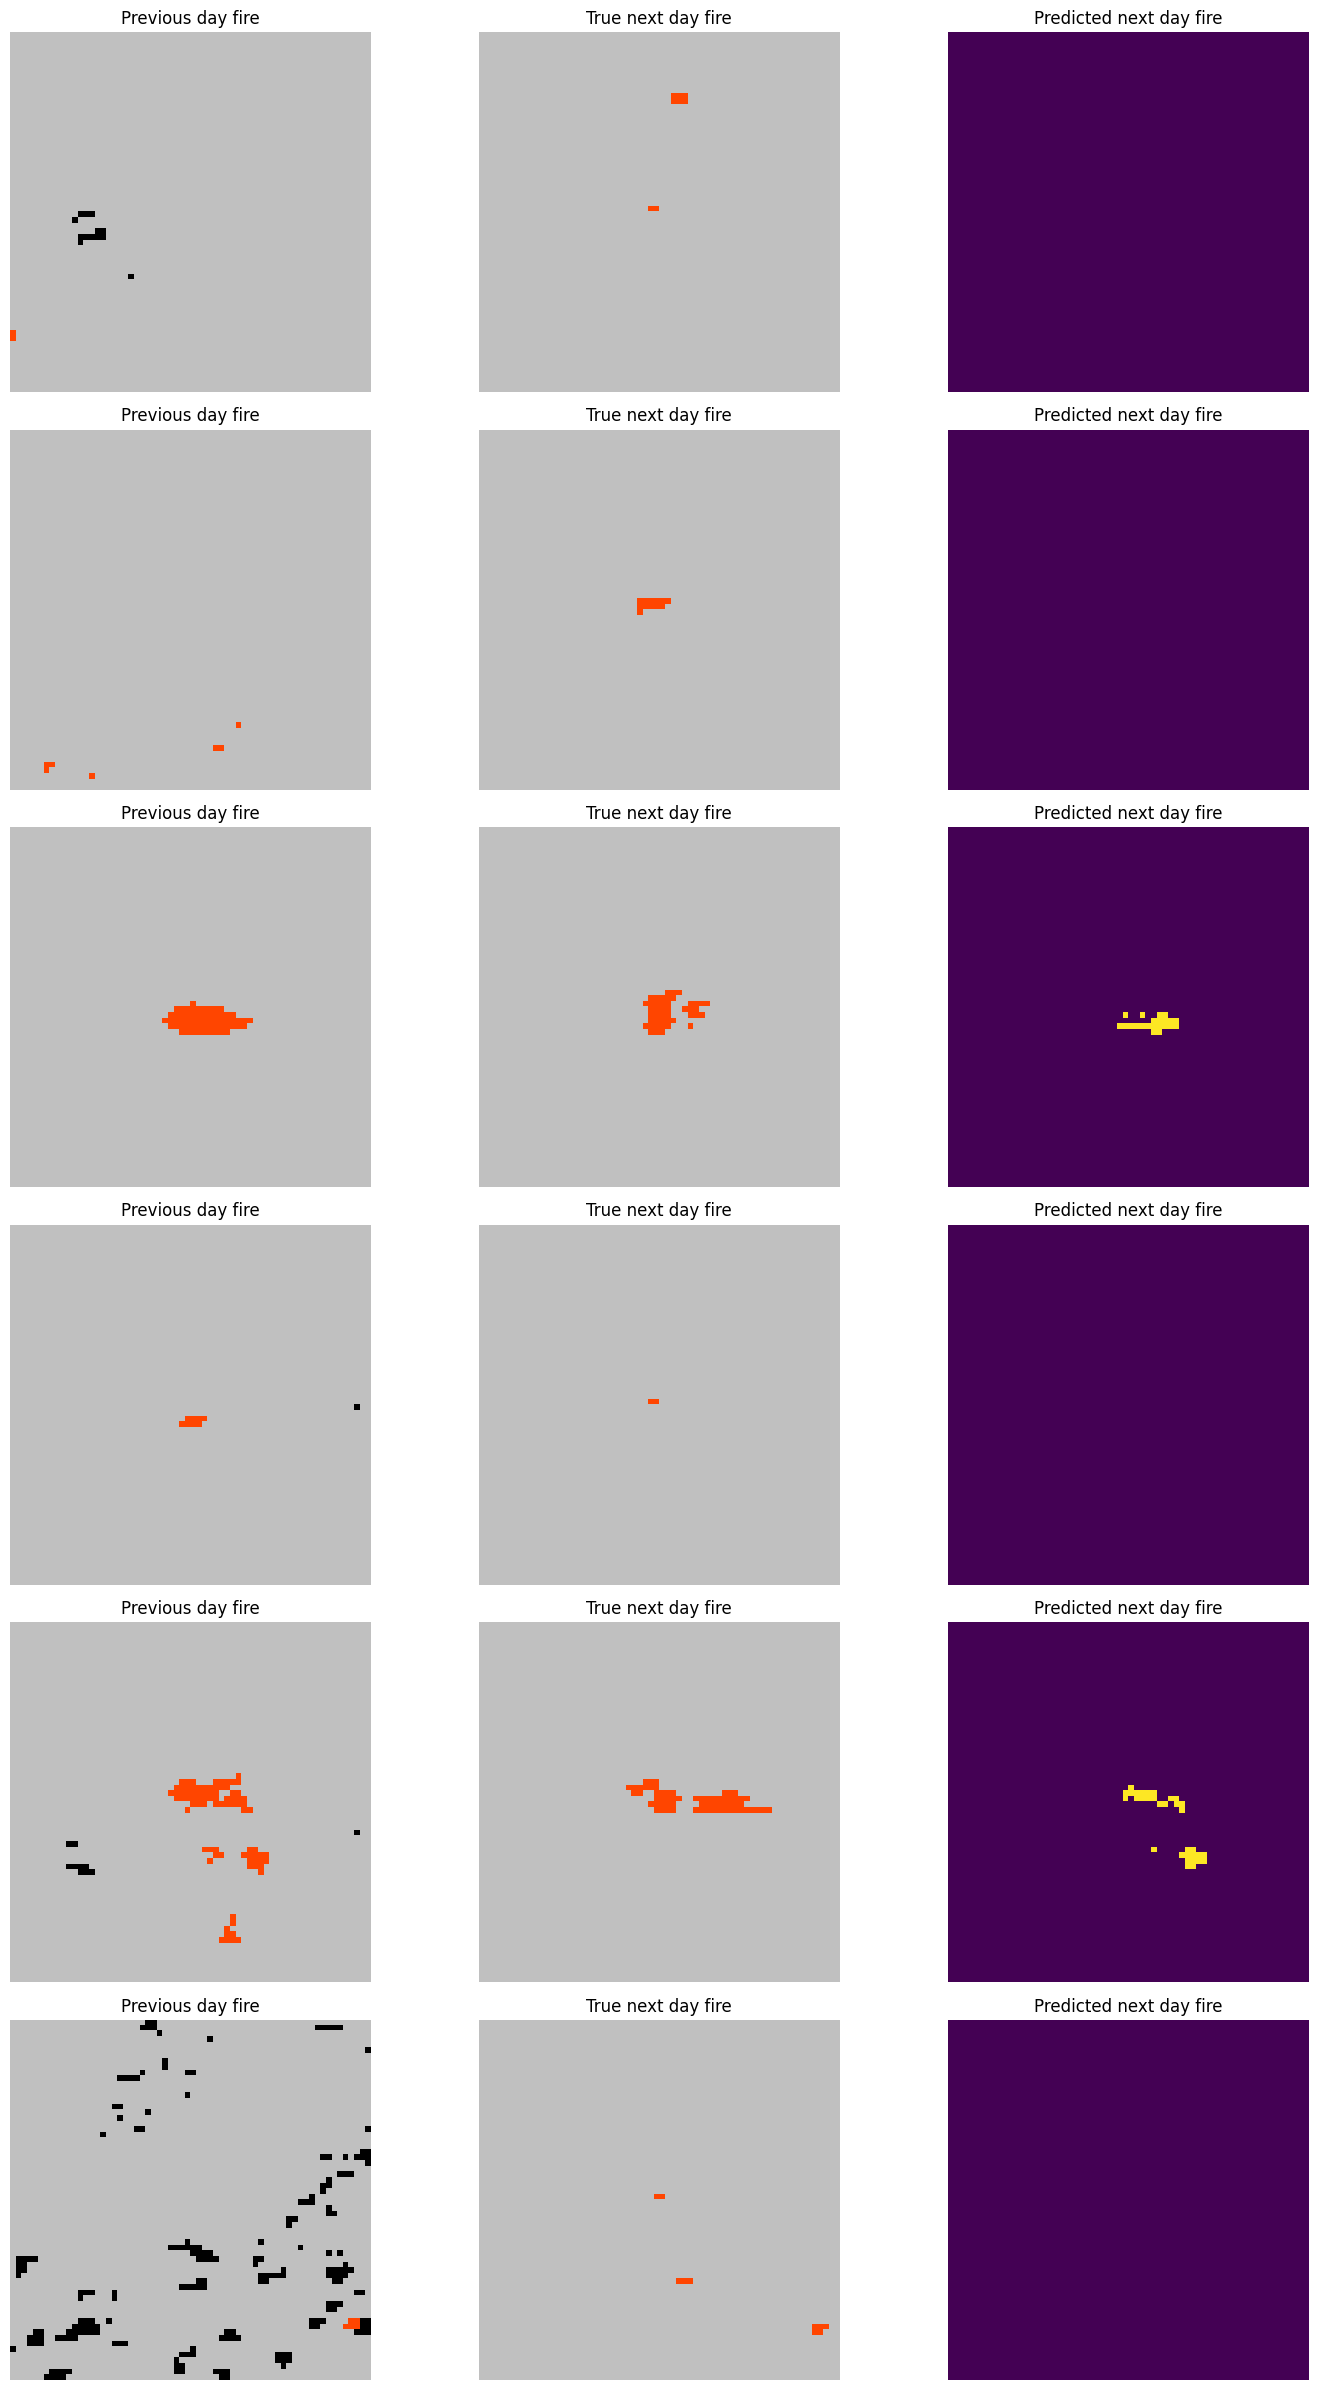

In [ ]:
features, labels = next(iter(test_dataset))
show_inference(6, features, labels, lambda x: tf.where(model.predict(x) > 0.5, 1, 0)[:,:,:,0])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 32)     │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 1)      │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,025 (50.88 KB)

 Trainable params: 12,897 (50.38 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/2
    469/Unknown 282s 575ms/step - accuracy: 0.8845 - loss: 0.3883

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


469/469 ━━━━━━━━━━━━━━━━━━━━ 300s 613ms/step - accuracy: 0.8847 - loss: 0.3879 - val_accuracy: 0.9864 - val_loss: 0.0630
Epoch 2/2
469/469 ━━━━━━━━━━━━━━━━━━━━ 314s 614ms/step - accuracy: 0.9879 - loss: 0.0488 - val_accuracy: 0.9858 - val_loss: 0.0579
Evaluate on test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

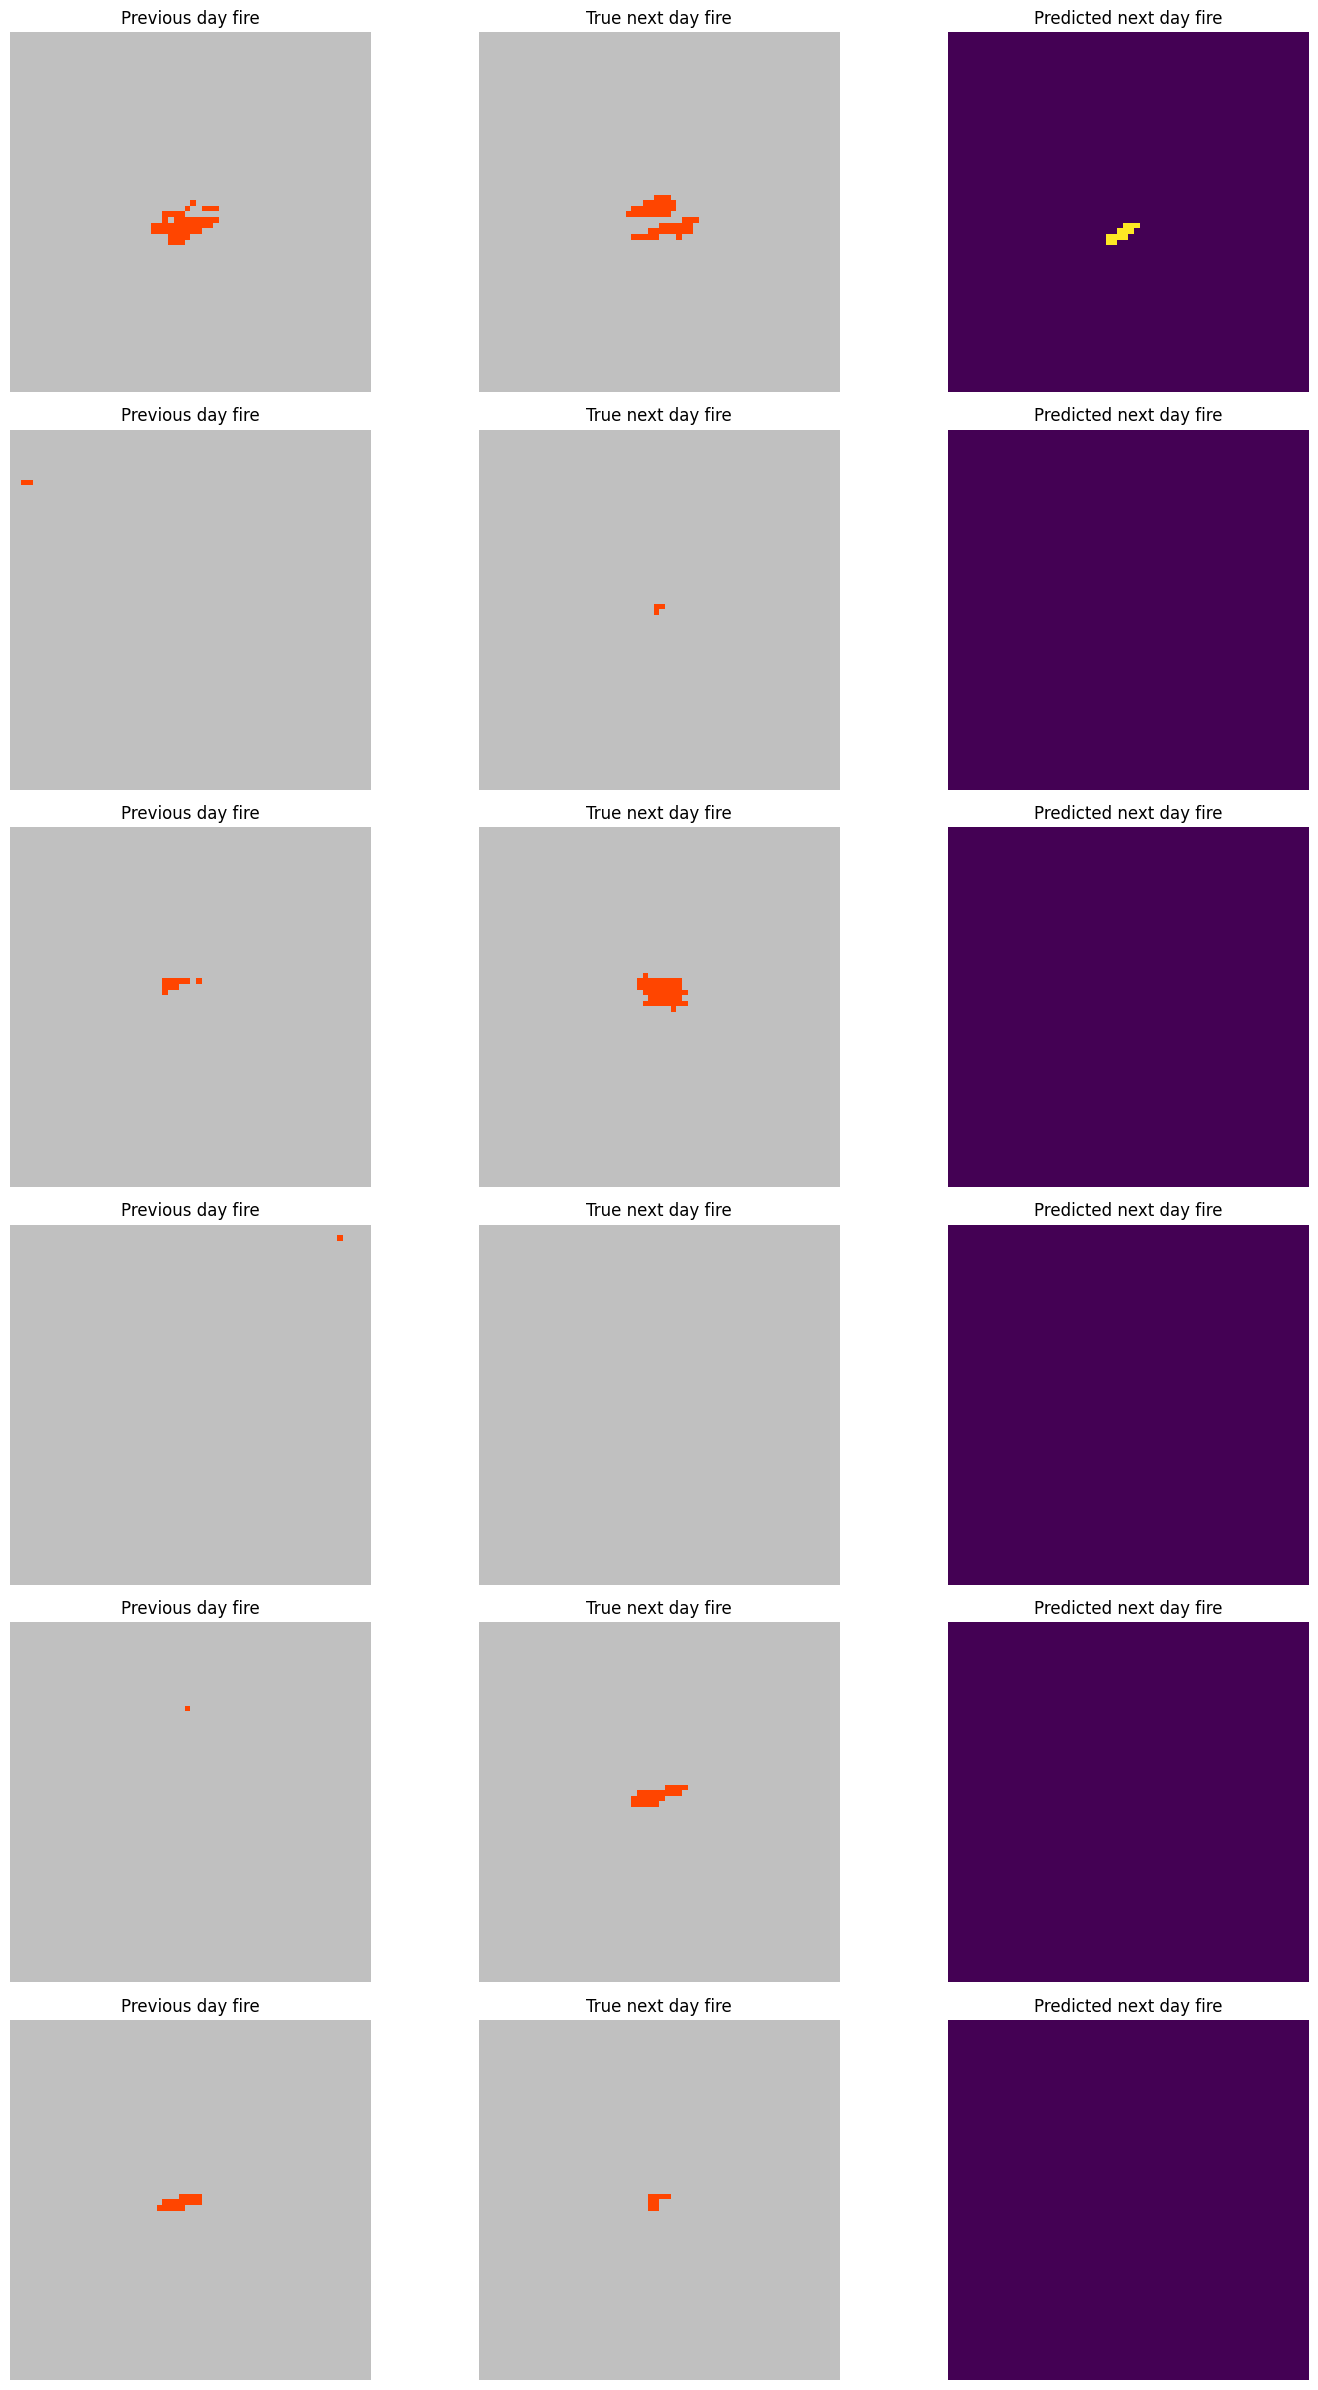

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm import tqdm
from typing import Callable

# Features
INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']
OUTPUT_FEATURES = ['FireMask']

# TFRecord dataset loader and preprocessor
def get_dataset(file_pattern, batch_size: int) -> tf.data.Dataset:
    dataset = tf.data.Dataset.list_files(file_pattern)
    dataset = dataset.interleave(
        lambda x: tf.data.TFRecordDataset(x),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

def normalize_feature(feature, feature_name):
    if feature_name == 'PrevFireMask':
        return feature
    else:
        return (feature - tf.reduce_mean(feature)) / (tf.math.reduce_std(feature) + 1e-6)

def _parse_function(example_proto):
    feature_description = {
        feature_name: tf.io.FixedLenFeature([64, 64], tf.float32)
        for feature_name in INPUT_FEATURES + OUTPUT_FEATURES
    }
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)

    inputs_list = []
    for feature_name in INPUT_FEATURES:
        feature = tf.expand_dims(parsed_example[feature_name], axis=-1)
        normalized_feature = normalize_feature(feature, feature_name)
        inputs_list.append(normalized_feature)
    inputs = tf.concat(inputs_list, axis=-1)

    label = tf.expand_dims(parsed_example['FireMask'], axis=-1)
    label = tf.where(label < 0, 0.0, label)
    label = tf.where(label > 0, 1.0, label)
    return inputs, label

# File paths
train_file = ['/content/drive/MyDrive/wildfire/next_day_wildfire_spread_train_{:02d}.tfrecord'.format(i) for i in range(15)]
test_file = ['/content/drive/MyDrive/wildfire/next_day_wildfire_spread_test_{:02d}.tfrecord'.format(i) for i in range(2)]
validation_file = ['/content/drive/MyDrive/wildfire/next_day_wildfire_spread_eval_{:02d}.tfrecord'.format(i) for i in range(2)]

# Prepare datasets
BATCH_SIZE = 32
train_dataset = get_dataset(train_file, BATCH_SIZE)
validation_dataset = get_dataset(validation_file, BATCH_SIZE)
test_dataset = get_dataset(test_file, BATCH_SIZE)

# CNN Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_simple_cnn() -> Model:
    inputs = Input(shape=(64, 64, 12))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)
    return Model(inputs=inputs, outputs=outputs)

model = build_simple_cnn()
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# IoU metric
def IoU_metric(real_mask: tf.Tensor, predicted_mask: tf.Tensor) -> float:
    real_mask = tf.where(real_mask < 0, 0, real_mask)
    intersection = np.logical_and(real_mask, predicted_mask)
    union = np.logical_or(real_mask, predicted_mask)
    return 1 if np.sum(union) == 0 else np.sum(intersection) / np.sum(union)

def evaluate_model(model, eval_dataset: tf.data.Dataset) -> float:
    IoU_measures = []
    for inputs, labels in eval_dataset:
        predictions = model.predict(inputs)
        predictions = tf.where(predictions > 0.5, 1, 0)
        for i in range(inputs.shape[0]):
            IoU_measures.append(IoU_metric(labels[i, :, :, 0], predictions[i, :, :]))
    return np.mean(IoU_measures)

# Train the model (✅ fixed the issue by removing `batch_size=...`)
EPOCHS = 2
tf.random.set_seed(1337)
model.fit(train_dataset, epochs=EPOCHS, validation_data=validation_dataset)

# Evaluate on test data
print("Evaluate on test data")
IoU = evaluate_model(model, test_dataset)
print(f"IoU Score: {IoU:.4f}")

# Inference visualization
def show_inference(n_rows: int, features: tf.Tensor, label: tf.Tensor, prediction_function: Callable[[tf.Tensor], tf.Tensor]) -> None:
    CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
    BOUNDS = [-1, -0.1, 0.001, 1]
    NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

    fig = plt.figure(figsize=(15, n_rows * 4))
    prediction = prediction_function(features)

    for i in range(n_rows):
        plt.subplot(n_rows, 3, i * 3 + 1)
        plt.title("Previous day fire")
        plt.imshow(features[i, :, :, -1], cmap=CMAP, norm=NORM)
        plt.axis('off')

        plt.subplot(n_rows, 3, i * 3 + 2)
        plt.title("True next day fire")
        plt.imshow(label[i, :, :, 0], cmap=CMAP, norm=NORM)
        plt.axis('off')

        plt.subplot(n_rows, 3, i * 3 + 3)
        plt.title("Predicted next day fire")
        plt.imshow(prediction[i, :, :])
        plt.axis('off')

    plt.tight_layout()

# Show some inference results
features, labels = next(iter(test_dataset))
show_inference(6, features, labels, lambda x: tf.where(model.predict(x) > 0.5, 1, 0)[:, :, :, 0])
